<h1><center> Group Assignment: Bird Classifier  </center></h1>

In [1]:
# Install Kaggle if not already installed
!pip install -q kaggle

# Make a directory for the Kaggle API key
!mkdir -p ~/.kaggle

# Upload the kaggle.json file (uncomment the below line if you haven't uploaded it yet)
from google.colab import files
files.upload()

# Move kaggle.json to the correct location
!mv kaggle.json ~/.kaggle/

# Set the appropriate permissions
!chmod 600 ~/.kaggle/kaggle.json

# Navigate to the competition dataset
competition_name = "aml-2024-feather-in-focus"

# Download the dataset
!kaggle competitions download -c $competition_name

# Unzip the dataset
!unzip -q *.zip


Saving kaggle.json to kaggle.json
 97% 704M/723M [00:04<00:00, 87.5MB/s]
100% 723M/723M [00:04<00:00, 162MB/s] 


In [2]:
# Import PyTorch and supporting libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from PIL import Image

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available. Running on Apple GPU.")
else:
    print("MPS backend is not available. Running on CPU.")


MPS backend is not available. Running on CPU.


In [4]:
# device = torch.device("mps")  # Use MPS for Apple Silicon
# x = torch.tensor([1.0, 2.0, 3.0], device=device)
# print("Tensor on MPS:", x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise CPU
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print(f"Tensor on {device}:", x)

Tensor on cuda: tensor([1., 2., 3.], device='cuda:0')


In [5]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Load the CSV file
# train data
train_csv_path = "/content/train_images.csv"
train_label_df = pd.read_csv(train_csv_path)

# test data
test_csv_path = "/content/test_images_path.csv"  # Update this path
test_label_df = pd.read_csv(test_csv_path)
# Drop the 'id' column
test_label_df = test_label_df.drop(columns=['id'])


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = "/content/train_images/"+self.data.iloc[idx, 0]  # Image file path
        label = self.data.iloc[idx, 1]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [6]:
class TestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = "/content/test_images/"+self.data.iloc[idx, 1]  # Image file path
        label = self.data.iloc[idx, 2]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [16]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset

# pre-process the data
# Define a transformation pipeline with resizing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images for restnet18
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [-1, 1]
])

batch_size = 16
learning_rate = 0.0001
num_epochs = 10

# Try validation / train split
from sklearn.model_selection import train_test_split
# # Split into training and validation sets
# X_train, X_val = train_test_split(train_csv_path, test_size=0.2, random_state=42)

# # print type of X_train
# print(type(X_train))
# # print type of train_csv_path
# print(type(train_csv_path))

# Instantiate the dataset
train_dataset = CustomDataset(csv_file=train_csv_path, transform=transform)
test_dataset = TestDataset(csv_file=test_csv_path, transform=transform)

# Get all indices
train_dataset_size = len(train_dataset)
indices = list(range(train_dataset_size))

# Split into train, validation, and test indices
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create Subsets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False) # set batch size to 1 so that we check all 4000 images

# Check sizes
print(f"Train dataset size: {len(train_subset)}")
print(f"Validation dataset size: {len(val_subset)}")


Train dataset size: 3140
Validation dataset size: 786


In [17]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Pre-process the data
# Define a transformation pipeline with resizing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images for ResNet18
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [-1, 1]
])

batch_size = 32
learning_rate = 0.0001
num_epochs = 10

# Load the dataset
train_dataset = CustomDataset(csv_file=train_csv_path, transform=transform)
test_dataset = TestDataset(csv_file=test_csv_path, transform=transform)

# Get all indices
train_dataset_size = len(train_dataset)
indices = list(range(train_dataset_size))

# Split into train and validation indices
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create Subsets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# Calculate sample weights for WeightedRandomSampler
# Assuming the dataset returns (image, label) in its __getitem__ method
train_labels = [train_dataset[i][1] for i in train_indices]  # Extract labels for train subset
class_counts = np.bincount(train_labels)  # Count occurrences of each class
class_weights = 1.0 / class_counts  # Compute weights (inverse of class frequency)
sample_weights = [class_weights[label] for label in train_labels]  # Map weights to labels

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders
train_dataloader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler)  # Use sampler
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set batch size to 1 for testing all images

# Check sizes
print(f"Train dataset size: {len(train_subset)}")
print(f"Validation dataset size: {len(val_subset)}")


Train dataset size: 3140
Validation dataset size: 786


<ipython-input-17-8108c71d119b>:39: RuntimeWarning: divide by zero encountered in divide
  class_weights = 1.0 / class_counts  # Compute weights (inverse of class frequency)


In [18]:
# Access a batch of data
images, labels = next(iter(train_dataloader))
print("Batch of Images Shape:", images.shape)
print("Batch of Labels:", labels)

max_label = max(labels.max().item() for _, labels in train_dataloader)
print(f"Maximum label: {max_label}")

# Flatten all labels into a single tensor and compute unique classes
all_labels = []
for _, labels in train_dataloader:
    all_labels.extend(labels.numpy())  # Collect labels into a single list

num_classes = len(set(all_labels))  # Compute the number of unique classes
print(f"Number of classes: {num_classes}")

Batch of Images Shape: torch.Size([32, 3, 224, 224])
Batch of Labels: tensor([105, 175,  47,  47,  25,  81,  92, 161, 110, 197, 172,  86,  40, 177,
          6,  56,  39, 153, 120, 196, 158,  65,   3,  98, 182,  73, 141, 111,
         81,  29, 177, 106])
Maximum label: 200
Number of classes: 200


In [19]:
# Access a batch of data
images, labels = next(iter(val_dataloader))
print("Batch of Images Shape:", images.shape)
print("Batch of Labels:", labels)

max_label = max(labels.max().item() for _, labels in val_dataloader)
print(f"Maximum label: {max_label}")

# Flatten all labels into a single tensor and compute unique classes
all_labels = []
for _, labels in val_dataloader:
    all_labels.extend(labels.numpy())  # Collect labels into a single list

num_classes = len(set(all_labels))  # Compute the number of unique classes
print(f"Number of classes: {num_classes}")

Batch of Images Shape: torch.Size([32, 3, 224, 224])
Batch of Labels: tensor([149,  16, 189, 128,  74, 156,  22,  28, 140, 173,  12,  81,  82,  96,
         55,  89,  83,  44,   1, 120, 122,  55,  59,  77,  19, 178, 165, 152,
         10, 177,  24, 150])
Maximum label: 200
Number of classes: 188


In [20]:
# Iterate through the train DataLoader
for images, labels in train_dataloader:
    print(f"Batch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

# Iterate through the test DataLoader
for images, labels in test_dataloader:
    print(f"\nBatch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

Batch of images: torch.Size([32, 3, 224, 224])
Batch of labels: tensor([194,  28, 100,  41,  13, 147,   4,  92,  19, 150,  76,  24, 187, 158,
        180,   6,  46,  60, 190, 101,  65,   9,  35,  39, 123, 138, 179, 112,
         68, 198,   8, 116])

Batch of images: torch.Size([1, 3, 224, 224])
Batch of labels: tensor([1])


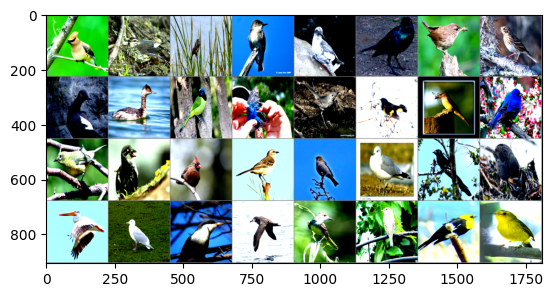

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [22]:
#Step 2: Define a simple CNN model
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(16 * 64 * 64, num_classes)  # 16 channels * 64x64 image size
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

#net = SimpleCNN().to(device) # if using simple CNN model TODO: try
# Load a pretrained ResNet model
net = models.resnet34(pretrained=True)
net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
def train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation step
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        val_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}, Val Accuracy: {val_accuracy}")
    return val_accuracy

In [24]:
print(net)

# Define a loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # would adding momentum do anything?
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Train and evaluate
accuracy = train_and_evaluate(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=20)

Epoch 1/20, Loss: 6.5465013301, Val Accuracy: 0.44783715012722647
Epoch 2/20, Loss: 3.311866447329521, Val Accuracy: 0.4643765903307888
Epoch 3/20, Loss: 4.381698681972921, Val Accuracy: 0.455470737913486
Epoch 4/20, Loss: 5.0458951238542795, Val Accuracy: 0.4592875318066158
Epoch 5/20, Loss: 2.5221416102722287, Val Accuracy: 0.45674300254452926
Epoch 6/20, Loss: 3.009378063492477, Val Accuracy: 0.4312977099236641
Epoch 7/20, Loss: 3.632034711074084, Val Accuracy: 0.4618320610687023
Epoch 8/20, Loss: 1.7389530562795699, Val Accuracy: 0.4440203562340967
Epoch 9/20, Loss: 1.9488526326604187, Val Accuracy: 0.4491094147582697
Epoch 10/20, Loss: 5.18894407665357, Val Accuracy: 0.4351145038167939
Epoch 11/20, Loss: 10.988624294288456, Val Accuracy: 0.42366412213740456
Epoch 12/20, Loss: 8.152747815474868, Val Accuracy: 0.405852417302799
Epoch 13/20, Loss: 11.061565730720758, Val Accuracy: 0.4223918575063613
Epoch 14/20, Loss: 5.720997094642371, Val Accuracy: 0.4300254452926209
Epoch 15/20, L

In [30]:
net.eval()  # Set model to evaluation mode

predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:  # Assuming dataset includes image paths
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = net(images)

        # Get predictions (no need to subtract or add indices unless necessary)
        _, preds = torch.max(outputs, 1)

        # Append predictions to the list
        predictions.extend(preds.cpu().numpy())  # Convert to list and extend the predictions list
        #predictions.append((image, preds.item()))

        # Append original labels for analysis
        all_labels.extend(labels.cpu().tolist())  # Convert labels to list and extend



In [31]:
torch.save(net.state_dict(), "resnet34WeightedAug.pth")

In [32]:
print(all_labels) # Only to see what is inside - not needed

# Save the predictions to a CSV file
df2 = pd.DataFrame(predictions, columns=['label'])
df2.index += 1  # Shift the index to start at 1
df2.to_csv("predictionsWeightedAug.csv", index=True, index_label='id')
print(df2.head())

[149, 16, 189, 128, 74, 156, 22, 28, 140, 173, 12, 81, 82, 96, 55, 89, 83, 44, 1, 120, 122, 55, 59, 77, 19, 178, 165, 152, 10, 177, 24, 150, 102, 6, 87, 118, 82, 70, 58, 7, 111, 56, 190, 48, 55, 94, 70, 1, 3, 123, 20, 40, 108, 22, 136, 94, 186, 29, 48, 177, 192, 93, 54, 180, 176, 67, 30, 75, 46, 189, 73, 180, 44, 85, 49, 39, 5, 83, 7, 81, 200, 19, 63, 76, 90, 25, 123, 77, 173, 16, 70, 71, 70, 67, 73, 156, 9, 67, 109, 36, 150, 171, 111, 35, 121, 15, 85, 82, 124, 106, 151, 27, 161, 130, 8, 88, 42, 115, 92, 25, 56, 63, 198, 9, 146, 16, 19, 1, 58, 83, 93, 12, 14, 122, 108, 87, 14, 32, 121, 38, 100, 18, 15, 196, 35, 31, 179, 3, 127, 14, 84, 23, 71, 93, 32, 100, 21, 37, 11, 143, 34, 29, 35, 135, 183, 133, 74, 25, 26, 11, 69, 17, 85, 199, 57, 33, 190, 51, 80, 94, 5, 171, 4, 188, 33, 54, 135, 191, 88, 100, 41, 38, 197, 1, 196, 62, 7, 198, 134, 124, 59, 84, 55, 91, 1, 8, 85, 168, 60, 47, 129, 80, 125, 93, 46, 88, 81, 11, 33, 4, 41, 36, 74, 57, 102, 57, 2, 170, 96, 132, 56, 3, 51, 39, 104, 49, 1

/Users/christinaperdue/anaconda3/envs/lab2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/christinaperdue/anaconda3/envs/lab2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


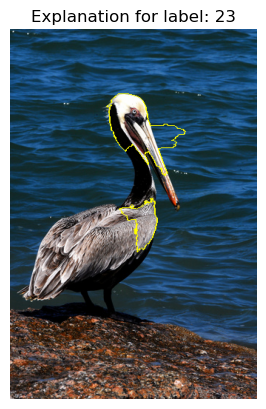

In [ ]:
#LIME Setup

# Import necessary libraries
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Step 1: Load the saved model
model = models.resnet18(pretrained=False)
model.load_state_dict(torch.load('christinaperdue_net.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Step 2: Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Step 3: Load and preprocess the image
test_image_path = 'data/test_images/test_images/1629.jpg'
image = Image.open(test_image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Step 4: Define the prediction function
def predict_function(images):
    """
    LIME expects a NumPy array as input.
    This function converts images back to PyTorch tensors, predicts, and outputs probabilities.
    """
    images = torch.tensor(images).permute(0, 3, 1, 2)  # Convert to (batch, channels, height, width)
    images = images.float() / 255  # Scale pixel values to [0, 1]

    # Normalize images like in preprocessing
    for i in range(images.shape[0]):
        images[i] = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(images[i])

    with torch.no_grad():
        outputs = model(images)  # Get logits
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert to probabilities
    return probabilities.numpy()

# Step 5: Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Step 6: Generate explanation
explanation = explainer.explain_instance(
    np.array(image),  # Pass the image as a NumPy array
    predict_function,  # The prediction function
    top_labels=5,  # Number of top labels to explain
    hide_color=0,  # Hide regions with zero color
    num_samples=1000  # Number of perturbed samples
)

# Step 7: Visualize the explanation
from matplotlib import pyplot as plt

# Choose the label to visualize
label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Display the explanation
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Explanation for label: {label}")
plt.axis('off')
plt.show()